## 思路：
1.将文件夹中的txt文件读取出来（去重）放入集合，然后对他们进行切词，并且分为训练和测试集
2.将词根据词频从大到小排列放入列表，选取特征词
3.将训练集和测试集的词和选取的特征词进行比较，得到特征词训练和测试集
4.将得到的训练集和测试集放入nltk分类器，得到正确率

In [1]:
#coding: utf-8
import os
import jieba  #process Chinese
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [2]:
#remove repeated
def make_word_set(words_file):
    words_set = set()
    with open(words_file, 'rb') as fp:
        for line in fp.readlines():
            word = line.strip().decode('utf-8')
            if len(word)>0 and word not in words_set:
                words_set.add(word)
    return words_set


In [3]:
def cloud(text):
    wordcloud = WordCloud(font_path = font, background_color="white",stopwords=stopwords_set).generate(" ".join([i for i in text]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Feature Words")
    plt.show()


In [4]:
def words_dict(all_words_list, deleteN, stopwords_set=set()):
    # choose feature words
    feature_words = []
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        if n > 2500:  # we just choose top 1000 featrues 
            break
        # drop stopwords in the text
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1 < len(
                all_words_list[t]) < 5:
            feature_words.append(all_words_list[t])
            n += 1
    return feature_words


In [5]:
def text_processing(folder_path, test_size=0.2):
    folder_list = os.listdir(folder_path)
    data_list = []
    class_list = []
    folder_id = 0
    # 遍历文件夹
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path, folder)
        files = os.listdir(new_folder_path)
        # 读取文件
        j = 1
        for file in files:
#             if j > 100:  # 怕内存爆掉，只取100个样本文件，你可以注释掉取完
#                 break
            with open(os.path.join(new_folder_path, file), 'rb') as fp:
                raw = fp.read().decode('utf-8')
            ## 是的，随处可见的jieba中文分词
            #jieba.enable_parallel(4)  # 开启并行分词模式，参数为并行进程数，不支持windows
            word_cut = jieba.cut(raw, cut_all=False)  # 精确模式，返回的结构是一个可迭代的genertor
            word_list = list(word_cut)  # genertor转化为list，每个词unicode格式
            #jieba.disable_parallel()  # 关闭并行分词模式

            data_list.append(word_list)  # 训练集list
            class_list.append(folder_id)
            # 类别
            j += 1
        folder_id += 1

    # 其实可以用sklearn自带的部分做
    train_data_list, test_data_list, train_class_list, test_class_list = train_test_split(data_list, class_list, test_size=test_size)

    all_words_dict = {}
    for word_list in data_list:
        words_dict = Counter([word for word in word_list])
        all_words_dict = dict(Counter(all_words_dict)+words_dict)
    # key函数利用词频进行降序排序
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f: f[1], reverse=True)  # 内建函数sorted参数需为list
    all_words_list = list(zip(*all_words_tuple_list))[0]

    return data_list, class_list, all_words_list, train_data_list, test_data_list, train_class_list, test_class_list


In [6]:
def text_features(data_list, train_data_list, test_data_list,  feature_words, flag='nltk'):
    def text_features(text, feature_words):
        text_words = set(text)
        ## -----------------------------------------------------------------------------------
        if flag == 'nltk':
            ## nltk特征 dict
            features = {word:1 if word in text_words else 0 for word in feature_words}
        elif flag == 'CNN':
            ## sklearn特征 list
            features = [word for word in feature_words if word in text_words]
        else:
            features = []
        ## -----------------------------------------------------------------------------------
        return features
    data = [text_features(text, feature_words) for text in data_list]
    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]
    return data, train_feature_list, test_feature_list


In [7]:
print ("start")


## 文本预处理
folder_path = 'Database/SogouC/Sample'
data_list, class_list, all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = text_processing(folder_path, test_size=0.2)

# 生成stopwords_set
stopwords_file = 'stopwords_cn.txt'
stopwords_set = make_word_set(stopwords_file)

## 文本特征提取和分类
# flag = 'nltk'
flag = 'CNN'
test_accuracy_list = []
deleteN = 20
feature_words = words_dict(all_words_list, deleteN, stopwords_set)
data, train_feature_list, test_feature_list = text_features(data_list, train_data_list, test_data_list, feature_words, flag)

data_list = []
pure_txt = ''
for item in data:    
    data_list.append(pure_txt.join(item))
print(data_list[0])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Windows\TEMP\jieba.cache


start


Loading model cost 0.797 seconds.
Prefix dict has been built succesfully.


中国一个城市社会通过问题安全提供活动已经参与没有需要今年重要影响成为希望项目进行不同领域目前孩子行为世界方式管理信息数据可能帮助组织方面时间很多关注文化提升获得应该数量分享中心结果合作培养发现参加选择带来内容建立一样推动使用不会公众精神显示情况行动报道一种比较指出整个媒体陪伴要求加强这是黄晓明美国发布各种几个一次阅读最大这次挑战万人发起建设原因一位不能形成利用志愿者起来开展微信银行举办注意接受得到出版社不要有效形式一名小时达到尤其更是知道经验政府准备之间不少捐赠感受家庭产生捐款设计来看其实作用一下网络交流表现大众痛点这一真正基本社区专门激发努力习惯号召一件图书馆人群完全公共氛围亲自日常因素反应之前邀请现实几乎舆论程度担心读者相信旨在成立国外感到质疑人员事实空间难以争相规定最终事情留下有人一份全民读书整体搭建民众进步期待免费部门网友点滴制造热爱认真危险达成效应市民覆盖表演家长背后预期创意核心往往聚焦监督主动模仿具体显得视频效果成熟类似观察心情捐出素养收益自我网站测试培育自发推广放置场所已有学霸游戏有着费用参与者精心一地遭遇源于文明图书一场流行很少乐于只能地铁终生细化


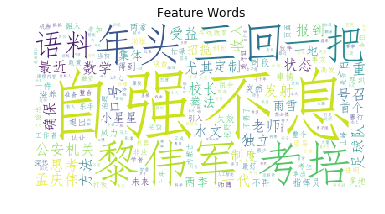

In [8]:
font = r'C:\Windows\Fonts\simfang.ttf'
cloud(feature_words)

In [9]:
import pandas as pd

pn = pd.DataFrame(data_list)
cw = lambda x: list(jieba.cut(x))
pn['word'] = pn[0].apply(cw)
print(pn['word'].head())
w = []
for i in pn['word']:
    w.extend(i)

dict = pd.DataFrame(pd.Series(w).value_counts())
dict['id']=list(range(1,len(dict)+1))
print(dict['id'].head())
get_sent = lambda x: list(dict['id'][x])
pn['sent'] = pn['word'].apply(get_sent)
print(pn['sent'].head())
print(pn['sent'].tail())

0    [中国, 一个, 城市, 社会, 通过, 问题, 安全, 提供, 活动, 已经, 参与, 没...
1    [发展, 教育, 中国, 一个, 社会, 通过, 学生, 活动, 已经, 没有, 老师, 教...
2    [中国, 一个, 社会, 国家, 记者, 重要, 影响, 一起, 生活, 我国, 行为, 可...
3    [一个, 社会, 企业, 提供, 记者, 参与, 腾讯, 需要, 北京, 重要, 过程, 成...
4    [发展, 中国, 一个, 学生, 问题, 学习, 没有, 腾讯, 研究, 北京, 影响, 成...
Name: word, dtype: object
一个    1
没有    2
很多    3
可能    4
已经    5
Name: id, dtype: int64
0    [9, 1, 239, 43, 38, 19, 595, 133, 105, 5, 143,...
1    [83, 144, 9, 1, 43, 38, 320, 105, 5, 2, 482, 2...
2    [9, 1, 43, 111, 207, 42, 47, 54, 51, 107, 156,...
3    [1, 43, 292, 133, 207, 143, 916, 23, 103, 42, ...
4    [83, 9, 1, 320, 19, 228, 2, 916, 68, 103, 47, ...
Name: sent, dtype: object
199    [692, 1, 19, 228, 5, 2, 916, 54, 73, 53, 27, 4...
200    [51, 2223, 162, 7, 341, 49, 784, 811, 126, 122...
201    [1, 143, 2, 201, 4, 114, 21, 2527, 18, 16, 604...
202    [5, 88, 265, 62, 20, 28, 12, 30, 299, 466, 40,...
203    [24, 51, 123, 13, 10, 31, 7, 71, 118, 8, 57, 1...
Name: sent, dtype: object


In [10]:
# transefer to wordvector
import numpy as np
from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences  
from keras.utils.np_utils import to_categorical  
from keras.layers import Dense, Input, Flatten  
from keras.layers import Conv1D, MaxPooling1D, Embedding  
from keras.models import Model  
from keras.optimizers import *  
from keras.models import Sequential  
from keras.layers import Merge  
from keras.preprocessing import sequence
maxlen = 2500
print("Pad sequences (samples x time)")
pn['sent'] = list(sequence.pad_sequences(pn['sent'], maxlen=maxlen))
print(pn['sent'].head())

Using TensorFlow backend.


Pad sequences (samples x time)
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: sent, dtype: object


In [15]:
labels = to_categorical(np.asarray(class_list))
data = np.array(list(pn['sent']))

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)


In [16]:
# embedding layer
embedding_layer = Embedding(len(dict)+1,256,input_length=maxlen) 

print('Training model.')  
  
# train a 1D convnet with global maxpoolinnb_wordsg  
  
#left model kernel size 5*50（50 is dimensions of wordvector ）  
model_left = Sequential()  
#model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))  
model_left.add(embedding_layer)  
model_left.add(Conv1D(128, 2, activation='tanh'))  
model_left.add(MaxPooling1D(2))  
model_left.add(Conv1D(128, 2, activation='tanh'))  
model_left.add(MaxPooling1D(2))  
model_left.add(Conv1D(128, 5, activation='tanh'))  
model_left.add(MaxPooling1D(10))  
model_left.add(Flatten())  
  
#right model <span style="font-family:Arial, Helvetica, sans-serif;">第二块神经网络，卷积窗口是4*50</span>  
  
model_right = Sequential()  
model_right.add(embedding_layer)  
model_right.add(Conv1D(128, 1, activation='tanh'))  
model_right.add(MaxPooling1D(4))  
model_right.add(Conv1D(128, 1, activation='tanh'))  
model_right.add(MaxPooling1D(4))  
model_right.add(Conv1D(128, 1, activation='tanh'))  
model_right.add(MaxPooling1D(20))  
model_right.add(Flatten())  
  
#third model <span style="font-family:Arial, Helvetica, sans-serif;">第三块神经网络，卷积窗口是6*50</span>  
model_3 = Sequential()  
model_3.add(embedding_layer)  
model_3.add(Conv1D(128, 3, activation='tanh'))  
model_3.add(MaxPooling1D(3))  
model_3.add(Conv1D(128, 3, activation='tanh'))  
model_3.add(MaxPooling1D(3))  
model_3.add(Conv1D(128, 3, activation='tanh'))  
model_3.add(MaxPooling1D(30))  
model_3.add(Flatten())  
  
  
merged = Merge([model_left, model_right,model_3], mode='concat') 
model = Sequential()  
model.add(merged) # add merge  
model.add(Dense(128, activation='tanh')) 
model.add(Dense(4, activation='softmax')) 
  
model.compile(loss='categorical_crossentropy',  
              optimizer='Adam',  
              metrics=['accuracy'])  

Training model.


C:\Users\zheng\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:44: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [17]:
model.fit(X_train, y_train, nb_epoch=100)  

score, acc = model.evaluate(X_test, y_test, batch_size=32, verbose=1)

C:\Users\zheng\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/100
142/142 [==============================] - 1s - loss: 1.1044 - acc: 0.4789     
Epoch 2/100
142/142 [==============================] - 0s - loss: 0.6772 - acc: 0.8451     
Epoch 3/100
142/142 [==============================] - 0s - loss: 0.3305 - acc: 0.9296     
Epoch 4/100
142/142 [==============================] - 0s - loss: 0.1966 - acc: 0.9296     
Epoch 5/100
142/142 [==============================] - 0s - loss: 0.1850 - acc: 0.9648     
Epoch 6/100
142/142 [==============================] - 0s - loss: 0.1094 - acc: 0.9577     
Epoch 7/100
142/142 [==============================] - 0s - loss: 0.0472 - acc: 1.0000     
Epoch 8/100
142/142 [==============================] - 0s - loss: 0.0389 - acc: 0.9789     
Epoch 9/100
142/142 [==============================] - 0s - loss: 0.0102 - acc: 1.0000     
Epoch 10/100
142/142 [==============================] - 0s - loss: 0.0085 - acc: 1.0000     
Epoch 11/100
142/142 [==============================] - 0s - loss: 0.0058 - acc

142/142 [==============================] - 0s - loss: 1.0622e-04 - acc: 1.0000     
Epoch 87/100
142/142 [==============================] - 0s - loss: 1.0434e-04 - acc: 1.0000     
Epoch 88/100
142/142 [==============================] - 0s - loss: 1.0251e-04 - acc: 1.0000     
Epoch 89/100
142/142 [==============================] - 0s - loss: 1.0063e-04 - acc: 1.0000     - ETA: 0s - loss: 8.9324e-05 - acc: 1.0
Epoch 90/100
142/142 [==============================] - 0s - loss: 9.8867e-05 - acc: 1.0000     
Epoch 91/100
142/142 [==============================] - 0s - loss: 9.7154e-05 - acc: 1.0000     
Epoch 92/100
142/142 [==============================] - 0s - loss: 9.5417e-05 - acc: 1.0000     
Epoch 93/100
142/142 [==============================] - 0s - loss: 9.3940e-05 - acc: 1.0000     
Epoch 94/100
142/142 [==============================] - 0s - loss: 9.2217e-05 - acc: 1.0000     
Epoch 95/100
142/142 [==============================] - 0s - loss: 9.0775e-05 - acc: 1.0000     
Epoc

Accuracy is:  1.0
[[11  0  0  0]
 [ 0 21  0  0]
 [ 0  0 14  0]
 [ 0  0  0 16]]


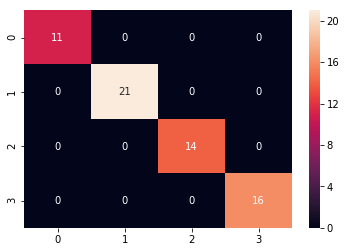

In [18]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_true = np.argmax(y_test,axis=1)
from sklearn.metrics import f1_score,confusion_matrix
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
ac = accuracy_score(y_true,y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_true,y_pred)
print(cm)
sns.heatmap(cm,annot=True,fmt="d")
plt.show()